In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import abc
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from tqdm import tqdm_notebook as tqdm
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import random
import time
import pandas as pd
import seaborn as sns
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D,AveragePooling2D,BatchNormalization,Activation,Dropout
import matplotlib.ticker as ticker
import tensorflow_addons as tfa
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
class AbstractLayer(tf.keras.layers.Layer):
    """Abstract Layer."""
    
    def __init__(self):
        """Inits the class."""
        super(AbstractLayer, self).__init__()
    
    @abc.abstractmethod
    def call(self, inputs):
        """Makes forward pass of the layer"""
        pass


class AbstractModel(tf.keras.Model):
    """Abstract model."""

    def __init__(self):
        """Inits the class."""
        super(AbstractModel, self).__init__()

    @abc.abstractmethod
    def call(self, inputs, training=False):
        """Makes forward pass of the network."""
        pass

    @abc.abstractmethod
    def fit(self, **kwargs):
        """Implements learning loop for the model.
        
        kwargs can contain optional parameters such as 
        num_epochs, batch_size, etc.
        """
        pass

    @abc.abstractmethod
    def predict(self, x):
        """Predicts outputs based on inputs (x)."""
        pass

In [4]:
cifar = tf.keras.datasets.cifar10

ORDERED_CLASS_NAMES=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

(x_train, y_train), (x_test, y_test) = cifar.load_data()

x_train, x_test = x_train / 255.0, x_test / 255.0
x_train[0].shape

(32, 32, 3)

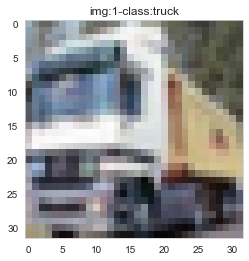

In [5]:
def plot_image(collection,number,labels=None,predicted=None):
    sns.set_style("whitegrid", {'axes.grid' : False})
    ax=plt.imshow(collection[number])
    title='img:'+str(number)
    if labels is not None:
        title+='-class:'+ORDERED_CLASS_NAMES[labels[number][0]]
    if predicted is not None:
        title+='-pred:'+ORDERED_CLASS_NAMES[predicted[number]]
    plt.title(title)
    plt.show()

plot_image(x_train,1,labels=y_train)

In [6]:
class ConvolutionBlock(tf.keras.Model):
    def __init__(self, pooling_type,kernel_size,batch_norm,residual):
        super(ConvolutionBlock, self).__init__()
        self.batch_norm=batch_norm
        self.residual=residual

        self.conv = Conv2D( kernel_size=kernel_size,strides=(1, 1),padding='same',filters=64)
        self.batch_norm=BatchNormalization()
        self.activation=Activation('relu')
        self.pooling=self.createPoolingLayer(pooling_type)  
    
    def createPoolingLayer(self,pooling_type):
        if pooling_type == 'max':
            return MaxPooling2D(pool_size=(3,3),strides=(2, 2))  
        else:
            if pooling_type == 'average':
                return AveragePooling2D(pool_size=(3,3),strides=(2, 2)) 
            else:
                return None
    

    def call(self, inputs, training=False):
        x = self.conv(inputs)
        if(self.batch_norm):
            x = self.batch_norm(x)
        
        if(self.residual):
            x = x + inputs
        x = self.activation(x)
        if(self.pooling != None):
            x = self.pooling(x)
        return x

In [7]:
class ConvolutionalModel(AbstractModel):

    def __init__(self,pooling_type,kernel_size,first_dense_size,dropout,batch_norm,residual):
        super(ConvolutionalModel, self).__init__()
        
        self.dropout=dropout
        
        self.conv_block1=ConvolutionBlock(pooling_type,kernel_size,batch_norm,residual=False) 
        self.conv_block2=ConvolutionBlock(pooling_type,kernel_size,batch_norm,residual) 
        
        self.flatten = Flatten()
        
        self.d1 = Dense(first_dense_size, activation='relu')
        self.dropout1=Dropout(0.75)
        self.d2 = Dense(384, activation='relu')
        self.dropout2=Dropout(0.75)
        self.d3 = Dense(192, activation='softmax')
         
        #STATISTICS
        self.train_learning_accuracy=[]
        self.test_learning_accuracy=[]
        self.train_learning_losses=[]
        self.test_learning_losses=[]
        self.test_f1=[]
    

        
    def call(self, inputs, training=False):
        """Makes forward pass of the network."""
        x = self.conv_block1(inputs)
        x = self.conv_block2(x)
        
        x = self.flatten(x)
        x = self.d1(x)
        if(self.dropout):
            x=self.dropout1(x)
        x = self.d2(x)
        if (self.dropout):
            x=self.dropout2(x)
        return self.d3(x)
    

    def predict(self, x):
        res=self.call(x)
        return np.argmax(res,axis=-1)
        
    
    @tf.function
    def train_step(self,images, labels,optimizer,loss_function, train_loss_metric,train_accuracy):
        with tf.GradientTape() as tape:
            predictions = self(images)
            loss = loss_function(labels, predictions)
        gradients = tape.gradient(loss, self.trainable_variables)
        optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        train_loss_metric(loss)
        train_accuracy(labels, predictions)
        
    @tf.function
    def test_step(self,images, labels,loss_function,test_loss_metric,test_accuracy):
        predictions = self(images)
        t_loss = loss_function(labels, predictions)
        test_loss_metric(t_loss)
        test_accuracy(labels, predictions)

    def fit(self,train_xs,train_ys,test_xs,test_ys,loss_function=tf.keras.losses.SparseCategoricalCrossentropy,
            epochs=10,optimizer=tf.keras.optimizers.Adam,learning_rate=0.001,batch_size=100,verbose=False,augmented=False):
        
        train_ds = tf.data.Dataset.from_tensor_slices((train_xs,train_ys)).shuffle(5000).batch(batch_size)
        
        test_ds = tf.data.Dataset.from_tensor_slices((test_xs, test_ys)).batch(batch_size)
        
#         optimizer = optimizer(learning_rate=learning_rate,weight_decay=1e-4)

        if(augmented):
            datagen = ImageDataGenerator(
            zoom_range=[0.5, 1.5],
            rotation_range=60,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True)

            datagen.fit(x_train)
        
        loss_function=loss_function()
        
        self.train_learning_accuracy=[]
        self.test_learning_accuracy=[]
        self.train_learning_losses=[]
        self.test_learning_losses=[]
        self.test_f1=[]

        train_loss_metric = tf.keras.metrics.Mean(name='train_loss_metric')
        train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

        test_loss_metric = tf.keras.metrics.Mean(name='test_loss_metric')
        test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')
        
        for epoch in tqdm(range(epochs)):
            
            if(augmented):
                batches = 0
                for batch_images, batch_labels in datagen.flow(x_train, y_train, batch_size=batch_size):
                    self.train_step(batch_images, batch_labels,optimizer,loss_function,train_loss_metric,train_accuracy)
                    batches += 1
                    if batches >= len(x_train) / batch_size:
                        break
            else:
                for batch_images,batch_labels in train_ds:
                    self.train_step(batch_images, batch_labels,optimizer,loss_function,train_loss_metric,train_accuracy)

            for test_images, test_labels in test_ds:
                self.test_step(test_images, test_labels,loss_function,test_loss_metric,test_accuracy)
                
            predicted_test=self.predict(test_xs)
            f1_test=f1_score(test_ys.transpose()[0], predicted_test, average='micro') 
            self.test_f1.append(f1_test)
                
            if verbose:
                template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
                print(template.format(epoch+1,
                            train_loss_metric.result(),
                            train_accuracy.result()*100,
                            test_loss_metric.result(),
                            test_accuracy.result()*100))
                
            self.train_learning_accuracy.append(train_accuracy.result().numpy()*100)
            self.test_learning_accuracy.append(test_accuracy.result().numpy()*100)
            self.train_learning_losses.append(train_loss_metric.result().numpy())
            self.test_learning_losses.append(test_loss_metric.result().numpy())

            # Reset the metrics for the next epoch
            train_loss_metric.reset_states()
            train_accuracy.reset_states()
            test_loss_metric.reset_states()
            test_accuracy.reset_states()

In [8]:
class ConvolutionalModelImproved(AbstractModel):

    def __init__(self,pooling_type,kernel_size,first_dense_size,dropout,batch_norm,residual):
        super(ConvolutionalModelImproved, self).__init__()
        
        self.dropout=dropout
        
        self.conv_block1=ConvolutionBlock(pooling_type,kernel_size,batch_norm,residual=False) 
        self.conv_block2=ConvolutionBlock(pooling_type,kernel_size,batch_norm,residual) 
        
        self.flatten = Flatten()
        
        self.d1 = Dense(first_dense_size, activation='relu')
        if(self.dropout!=None):
            self.dropout1=Dropout(dropout)
        self.d2 = Dense(384, activation='relu')
        if(self.dropout!=None):
            self.dropout2=Dropout(dropout)
        self.d3 = Dense(192, activation='softmax')
         
        #STATISTICS
        self.train_learning_accuracy=[]
        self.test_learning_accuracy=[]
        self.train_learning_losses=[]
        self.test_learning_losses=[]
        self.test_f1=[]
    

        
    def call(self, inputs, training=False):
        """Makes forward pass of the network."""
        x = self.conv_block1(inputs)
        x = self.conv_block2(x)
        
        x = self.flatten(x)
        x = self.d1(x)
        if(self.dropout!=None):
            x=self.dropout1(x)
        x = self.d2(x)
        if (self.dropout!=None):
            x=self.dropout2(x)
        return self.d3(x)
    

    def predict(self, x):
        res=self.call(x)
        return np.argmax(res,axis=-1)
        
    
    @tf.function
    def train_step(self,images, labels,optimizer,loss_function, train_loss_metric,train_accuracy):
        with tf.GradientTape() as tape:
            predictions = self(images)
            loss = loss_function(labels, predictions)
        gradients = tape.gradient(loss, self.trainable_variables)
        optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        train_loss_metric(loss)
        train_accuracy(labels, predictions)
        
    @tf.function
    def test_step(self,images, labels,loss_function,test_loss_metric,test_accuracy):
        predictions = self(images)
        t_loss = loss_function(labels, predictions)
        test_loss_metric(t_loss)
        test_accuracy(labels, predictions)

    def fit(self,train_xs,train_ys,test_xs,test_ys,loss_function=tf.keras.losses.SparseCategoricalCrossentropy,
            epochs=10,optimizer=tf.keras.optimizers.Adam,learning_rate=0.001,batch_size=100,verbose=False,augmented=False):
        
        train_ds = tf.data.Dataset.from_tensor_slices((train_xs,train_ys)).shuffle(5000).batch(batch_size)
        
        test_ds = tf.data.Dataset.from_tensor_slices((test_xs, test_ys)).batch(batch_size)
        
        if(augmented):
            datagen = ImageDataGenerator(
            zoom_range=[0.5, 1.5],
            rotation_range=60,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True)

            datagen.fit(x_train)
        
        loss_function=loss_function()
        
        self.train_learning_accuracy=[]
        self.test_learning_accuracy=[]
        self.train_learning_losses=[]
        self.test_learning_losses=[]
        self.test_f1=[]

        train_loss_metric = tf.keras.metrics.Mean(name='train_loss_metric')
        train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

        test_loss_metric = tf.keras.metrics.Mean(name='test_loss_metric')
        test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')
        
        for epoch in tqdm(range(epochs)):
            
            if(augmented):
                batches = 0
                for batch_images, batch_labels in datagen.flow(x_train, y_train, batch_size=batch_size):
                    self.train_step(batch_images, batch_labels,optimizer,loss_function,train_loss_metric,train_accuracy)
                    batches += 1
                    if batches >= len(x_train) / batch_size:
                        break
                        
                for batch_images,batch_labels in train_ds:
                    self.train_step(batch_images, batch_labels,optimizer,loss_function,train_loss_metric,train_accuracy)
            else:
                for batch_images,batch_labels in train_ds:
                    self.train_step(batch_images, batch_labels,optimizer,loss_function,train_loss_metric,train_accuracy)

            for test_images, test_labels in test_ds:
                self.test_step(test_images, test_labels,loss_function,test_loss_metric,test_accuracy)
                
            predicted_test=self.predict(test_xs)
            f1_test=f1_score(test_ys.transpose()[0], predicted_test, average='micro') 
            self.test_f1.append(f1_test)
                
            if verbose:
                template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
                print(template.format(epoch+1,
                            train_loss_metric.result(),
                            train_accuracy.result()*100,
                            test_loss_metric.result(),
                            test_accuracy.result()*100))
                
            self.train_learning_accuracy.append(train_accuracy.result().numpy()*100)
            self.test_learning_accuracy.append(test_accuracy.result().numpy()*100)
            self.train_learning_losses.append(train_loss_metric.result().numpy())
            self.test_learning_losses.append(test_loss_metric.result().numpy())

            # Reset the metrics for the next epoch
            train_loss_metric.reset_states()
            train_accuracy.reset_states()
            test_loss_metric.reset_states()
            test_accuracy.reset_states()

In [1]:
model_i=ConvolutionalModelImproved(pooling_type='max',kernel_size=(3,3),first_dense_size=1600,dropout=0.3,batch_norm=False,residual=False)
model_i.fit(x_train,y_train,x_test,y_test,verbose=True,learning_rate=0.0008,optimizer = tfa.optimizers.AdamW(learning_rate=0.0008,weight_decay=1e-4),augmented=True)

NameError: name 'ConvolutionalModelImproved' is not defined

In [202]:
def run_tests(file_name):
    EPOCHS=15
    KERNEL_SIZES=[(3,3,1600)]
    
    RESIDUAL=[False,True]
    AUGEMNTED=[False,True]
    
    DROPOUT=[False,True]
    BATCH_NORM=[True,False]
    OPTIMIZERS=[tf.optimizers.Adam(learning_rate=0.0005),tfa.optimizers.AdamW(learning_rate=0.0008,weight_decay=1e-4),tfa.optimizers.AdamW(learning_rate=0.006,weight_decay=0.0005)]
    OPTIMS_DESC=['ADAM,0.0005,WD=0','ADAM,0.0008,WD=0.0001','ADAM,0.006,WD=0.0005']

    df = pd.DataFrame(columns=['EPOCHS','OPTIM','RESIDUAL','AUGMENTED', 'DROPOUT','BATCH_NORM','ACC_TRAIN','ACC_TEST','TEST_F1','ERROR_TRAIN','ERROR_TEST'])
    df.to_csv('./csv/' + file_name + '.csv',index=False)
    
    for optim in OPTIMIZERS:
        desc=OPTIMS_DESC[OPTIMIZERS.index(optim)]
        for res in RESIDUAL:
            for aug in AUGEMNTED:
                for dropout in DROPOUT:
                    for batch_norm in BATCH_NORM:
                        t_model=ConvolutionalModel(pooling_type='max',kernel_size=(3,3),first_dense_size=1600,dropout=dropout,batch_norm=batch_norm,residual=res)
                        t_model.fit(x_train,y_train,x_test,y_test,verbose=False,optimizer = optim,augmented=aug,epochs=EPOCHS)

                        for epoch in range(EPOCHS):
                            acc_train=t_model.train_learning_accuracy[epoch]
                            acc_test=t_model.test_learning_accuracy[epoch]

                            error_train=t_model.train_learning_losses[epoch]
                            error_test=t_model.test_learning_losses[epoch]
                            f1=t_model.test_f1[epoch]

                            subdf=pd.DataFrame(zip([epoch+1],[desc],[res],[aug],[dropout],[batch_norm],[acc_train],[acc_test],[f1],[error_train],[error_test]),
                                               columns=['EPOCHS','OPTIM','RESIDUAL','AUGMENTED', 'DROPOUT','BATCH_NORM','ACC_TRAIN','ACC_TEST','TEST_F1','ERROR_TRAIN','ERROR_TEST'])

                            subdf.to_csv('./csv/' + file_name + '.csv', mode='a', header=False, index=False)

## Początkowe wyniki

In [9]:
def read_all_stats(dir_name,filenames):
    base=pd.DataFrame(zip([],[],[],[],[],[],[],[],[],[],[]),columns=['EPOCHS','OPTIM','RESIDUAL','AUGMENTED', 'DROPOUT','BATCH_NORM','ACC_TRAIN','ACC_TEST','TEST_F1','ERROR_TRAIN','ERROR_TEST'])
    for file in filenames:
        read_df=pd.read_csv(dir_name+'/'+file+'.csv')
        base=base.append(read_df)
    return base

results=read_all_stats('res1',['statistics','statistics2','statistics3','statistics5'])


In [10]:
results.sort_values(by=['ACC_TEST'], ascending=False)[:10]

,EPOCHS,OPTIM,RESIDUAL,AUGMENTED,DROPOUT,BATCH_NORM,ACC_TRAIN,ACC_TEST,TEST_F1,ERROR_TRAIN,ERROR_TEST
128,9,"ADAM,0.0009,WD=0.0001",True,False,False,True,90.138000,76.969999,0.7697,0.283850,0.772012
130,11,"ADAM,0.0008,WD=0.0001",False,False,False,True,93.687999,76.760000,0.7676,0.187692,0.896228
128,9,"ADAM,0.0008,WD=0.0001",False,False,False,True,89.573997,76.670003,0.7667,0.301674,0.782848
130,11,"ADAM,0.0009,WD=0.0001",True,False,False,True,93.839997,76.630002,0.7663,0.177710,0.868417
129,10,"ADAM,0.0009,WD=0.0001",True,False,False,True,92.272002,76.490003,0.7649,0.223371,0.841301
248,9,"ADAM,0.0005,WD=0",False,False,False,True,87.971997,76.470000,0.7647,0.341675,0.790122
133,14,"ADAM,0.0008,WD=0.0001",False,False,False,True,96.447998,76.359999,0.7636,0.108695,0.941533
253,14,"ADAM,0.0005,WD=0",False,False,False,True,96.873999,76.330000,0.7633,0.089490,1.134860
65,6,"ADAM,0.0008,WD=0",True,False,False,True,84.701997,76.289999,0.7629,0.436410,0.755130
66,7,"ADAM,0.0008,WD=0",True,False,False,True,88.463998,76.270002,0.7627,0.329704,0.790289


In [11]:
all_results=read_all_stats('res1',['statistics','statistics2','statistics3','statistics5'])

### Wpływ weight decay = 0.0001 w optymalizatorze Adam

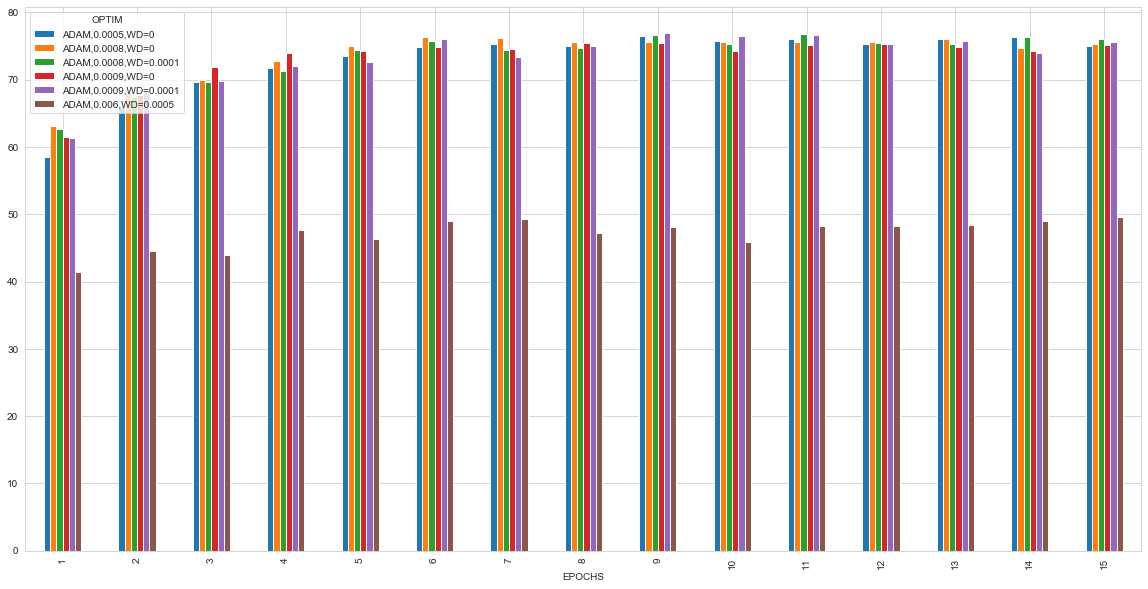

In [12]:
sns.set_style("whitegrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(20,10))
all_results.groupby(['EPOCHS','OPTIM',]).max()['ACC_TEST'].unstack().plot.bar(ax=ax)

#### Wniosek
Po odpowiednio długim uczeniu (od 9 epoki wzwyż) dodanie regularyzacji poprzez Weight Decay w optymalizatorze Adam pozwoliło na uzyswiwanie lepszych maksymalnych wyników.

### Wpływ Batch Normalization

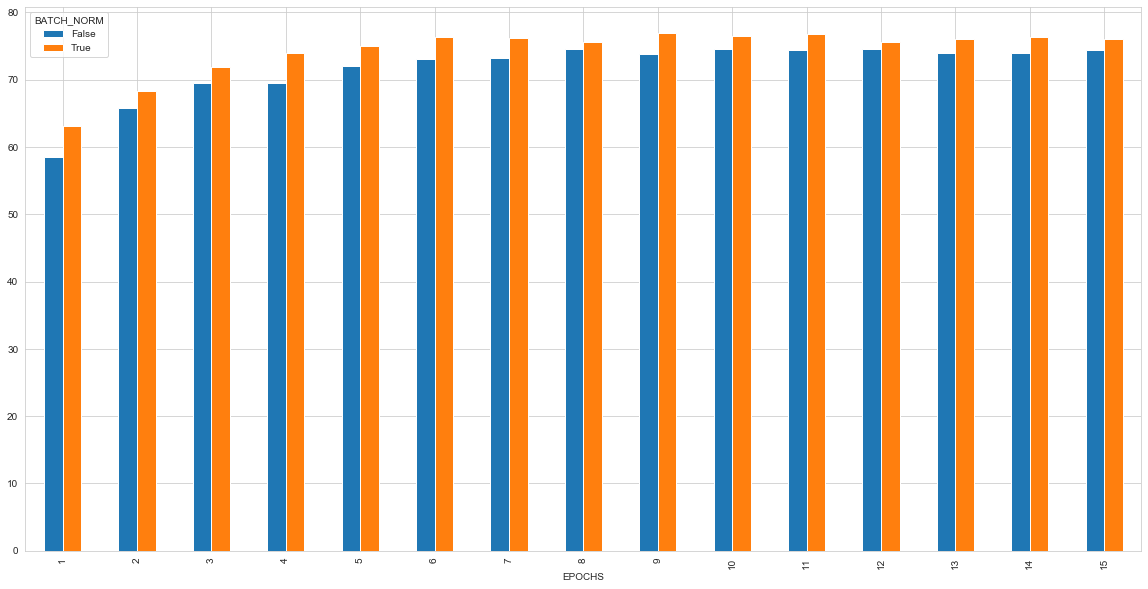

In [36]:
sns.set_style("whitegrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(20,10))
all_results.groupby(['EPOCHS','BATCH_NORM',]).max()['ACC_TEST'].unstack().plot.bar(ax=ax)

Batch Normalization wpływa na poprawę wyników.

### Wpływ połączeń rezydualnych

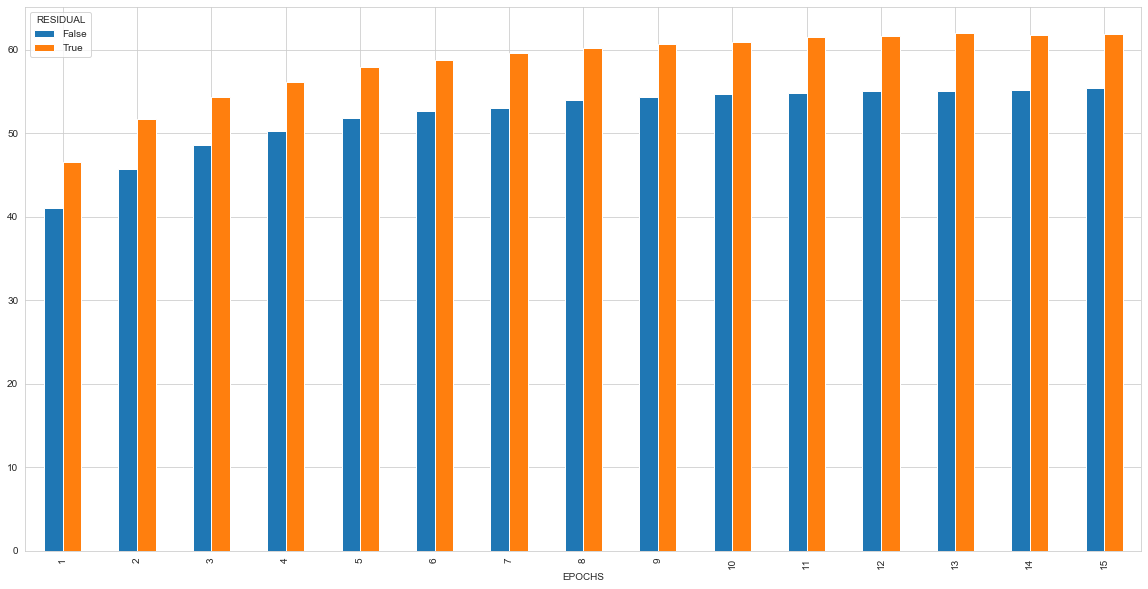

In [39]:
sns.set_style("whitegrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(20,10))
all_results.groupby(['EPOCHS','RESIDUAL',]).mean()['ACC_TEST'].unstack().plot.bar(ax=ax)

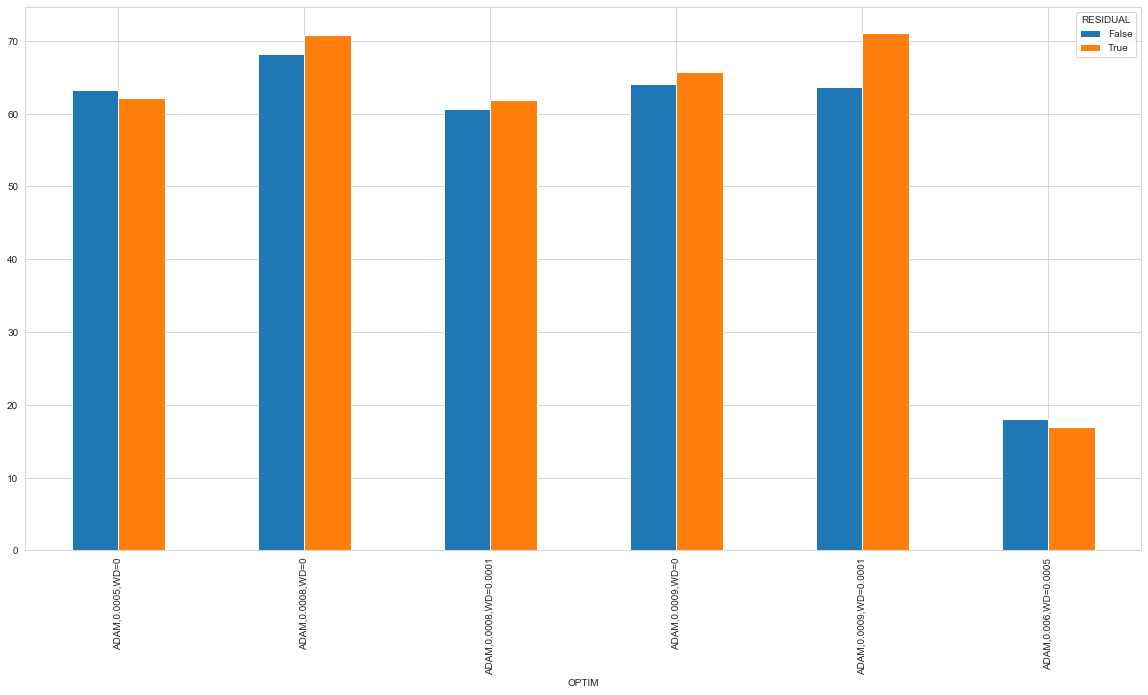

In [61]:
sns.set_style("whitegrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(20,10))
all_results.groupby(['OPTIM','RESIDUAL']).mean()['ACC_TEST'].unstack().plot.bar(ax=ax)

#### Wniosek:
Zastoswanie połączeń rezydualnych przyniosło poprawę względem ich braku. Poprawa ta była dużo bardziej widoczna dla skutecznych optymalizatorów.

### Wpływ dropoutu 0.75

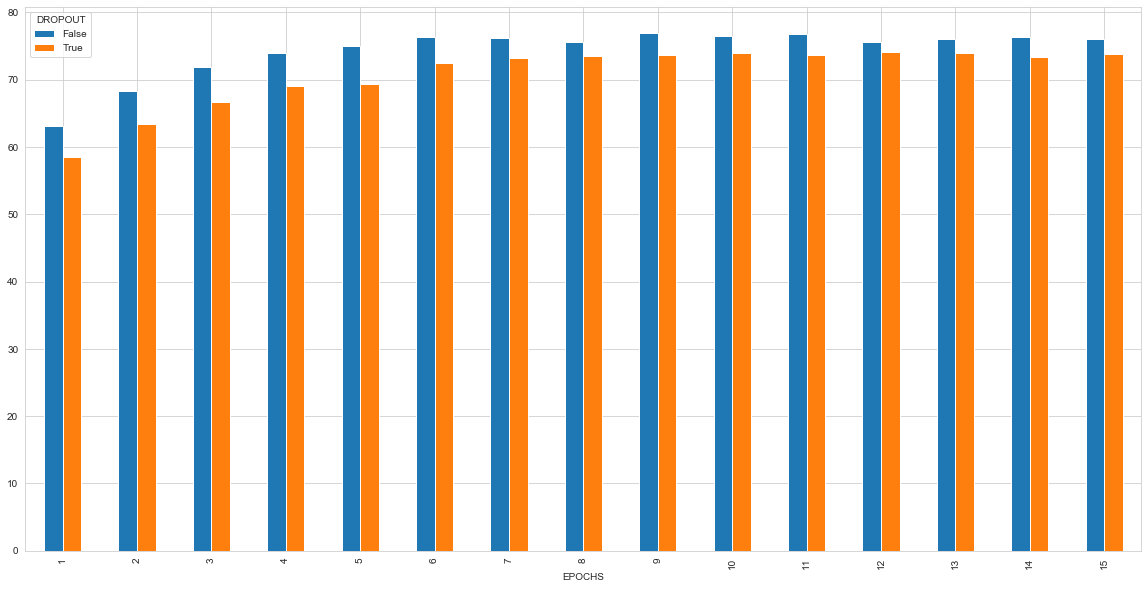

In [35]:
sns.set_style("whitegrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(20,10))
all_results.groupby(['EPOCHS','DROPOUT',]).max()['ACC_TEST'].unstack().plot.bar(ax=ax)

Wniosek - dropout 0.75 nie jest korzystny. Możliwe, że dałby poprawę wyników przy uczeniu z większą liczbą epok.

#### Poszerzone badania 
Zbadano dodatkowo wpływ dropoutu dla najlepszego dotychczas otrzymanego modelu z innymi wartościami procentowymi droputu: 0,0.1,0.2,0.4,0.5,0.75,0.9. Badany model to ADAM,0.0009,WD=0.0001 z znachowaniem polączeń rezydualnych i Batch Normalization.

In [66]:
dropout_df=pd.read_csv('res1/dropout.csv',sep=';')

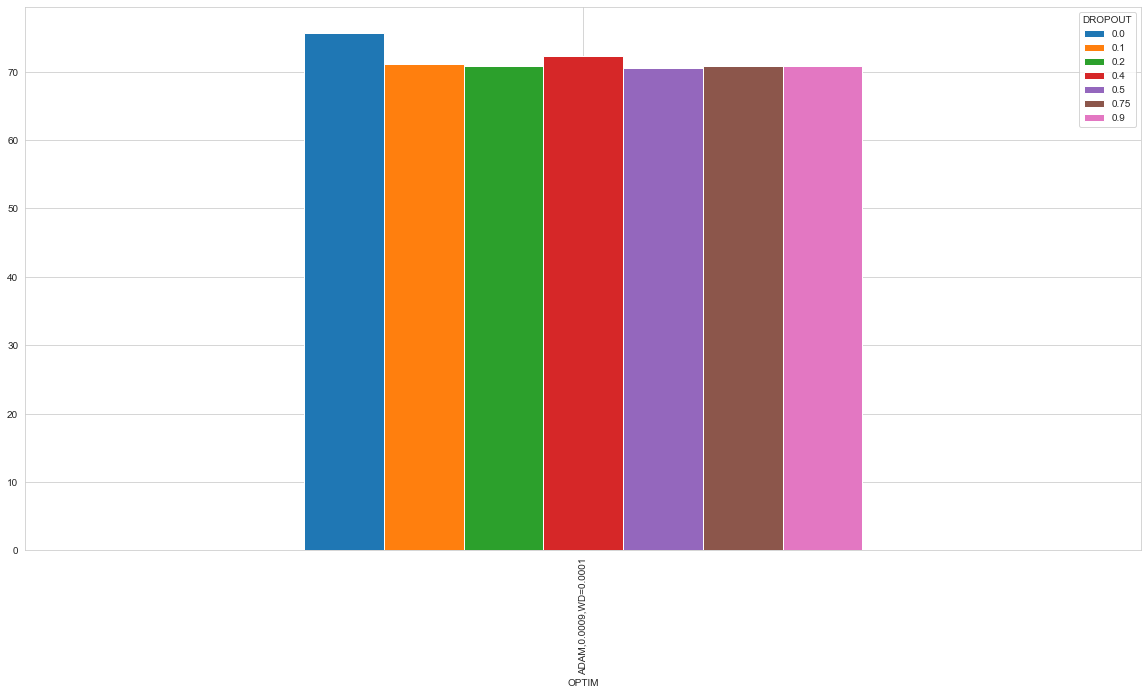

In [69]:
sns.set_style("whitegrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(20,10))
dropout_df.groupby(['OPTIM','DROPOUT',]).max()['ACC_TEST'].unstack().plot.bar(ax=ax)

Wniosek dropout nie przynosi poprawy efektów.

#### Bez powiązania z innymi sposobami regularyzacji

In [73]:
dropout_df_2=pd.read_csv('res1/dropout2.csv',sep=';')

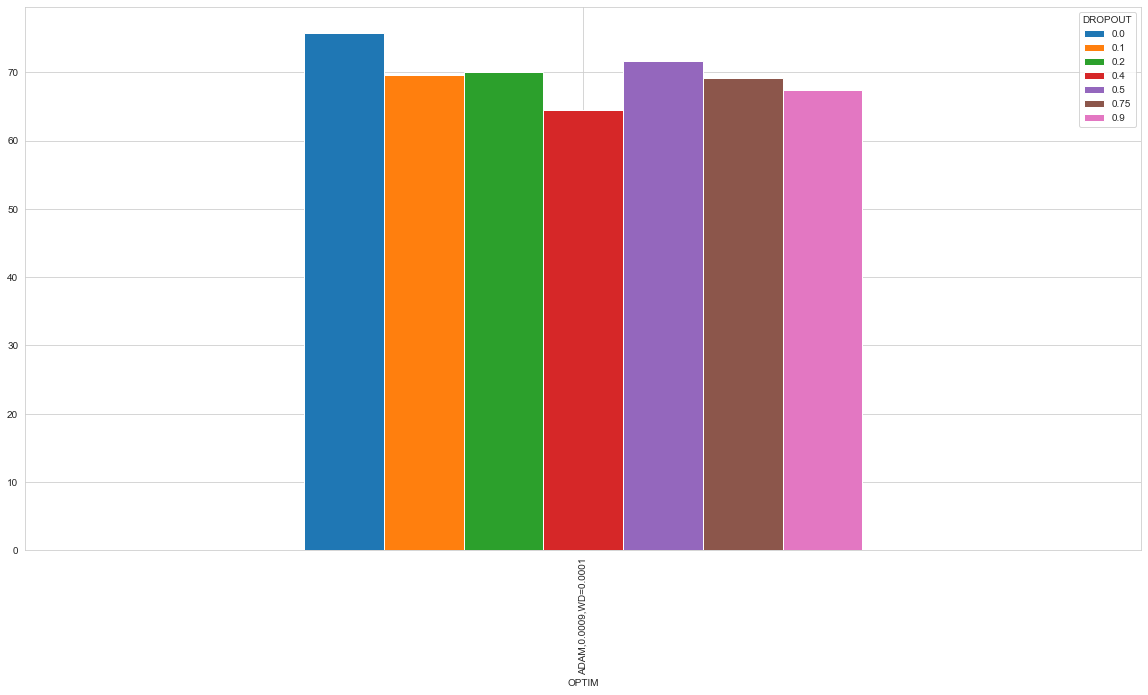

In [76]:
sns.set_style("whitegrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(20,10))
dropout_df_2.groupby(['OPTIM','DROPOUT',]).max()['ACC_TEST'].unstack().plot.bar(ax=ax)

Dropout zarówno w przypadku powiązania z innymi metodami regualryzacji, jak i zastosowany osobno nie przyniósł poprawy. Możliwe, że w takim przypadku czas uczenia siecie był za krótki lub zastosowana architektura nie sporzyja wykorzytywaniu dropoutu w ostatniych warstwach w pełni połączonych.

### Wpływ rozszerzania zbioru danych

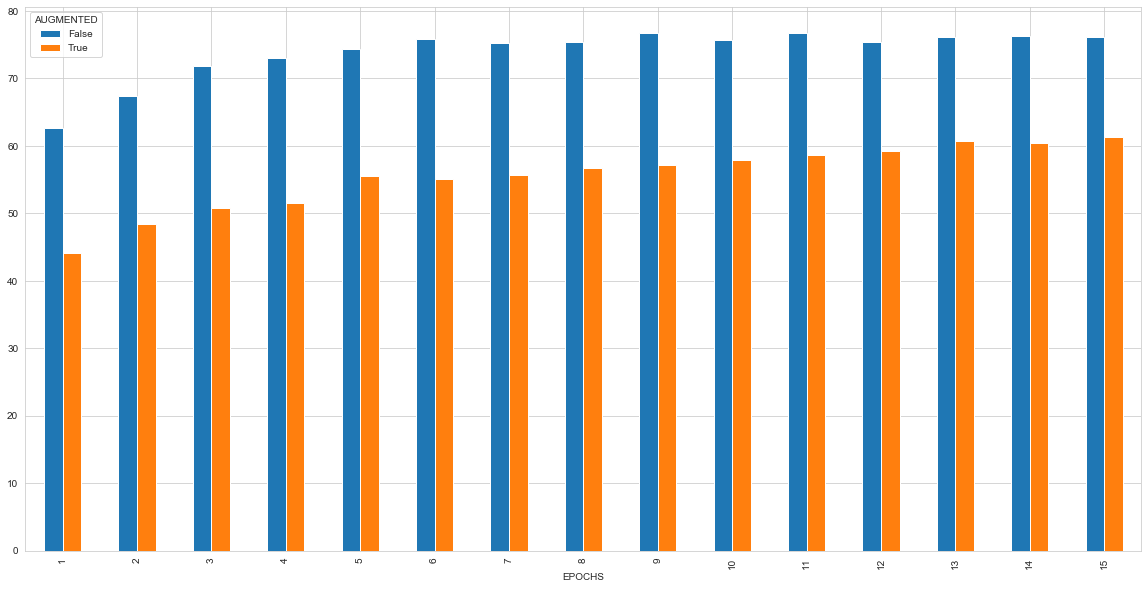

In [28]:
sns.set_style("whitegrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(20,10))
all_results.groupby(['EPOCHS','AUGMENTED',]).max()['ACC_TEST'].unstack().plot.bar(ax=ax)

### Wniosek 
Poszerzanie zbioru dancych nie zostało wykonane poprawnie - nie przyniosło efektów.
Postanowiono wprowadzić korektę do modelu - wynkonywano uczenie na większej liczbie wzorców.

In [82]:
improved=pd.read_csv('res1/augmented.csv')

In [83]:
improved.sort_values(by=['ACC_TEST'], ascending=False)[:10]

,EPOCHS,OPTIM,RESIDUAL,AUGMENTED,DROPOUT,BATCH_NORM,ACC_TRAIN,ACC_TEST,TEST_F1,ERROR_TRAIN,ERROR_TEST
12,13,"ADAM,0.0009,WD=0.0001",True,True,0.0,True,75.195998,78.320003,0.7832,0.707370,0.783016
13,14,"ADAM,0.0009,WD=0.0001",True,True,0.0,True,75.678003,77.920002,0.7792,0.696420,0.799456
11,12,"ADAM,0.0009,WD=0.0001",True,True,0.0,True,74.764001,77.829999,0.7783,0.720614,0.808652
14,15,"ADAM,0.0009,WD=0.0001",True,True,0.0,True,76.052999,77.560002,0.7756,0.684655,0.823201
10,11,"ADAM,0.0009,WD=0.0001",True,True,0.0,True,74.138999,77.139997,0.7714,0.735254,0.788943
7,8,"ADAM,0.0009,WD=0.0001",True,True,0.0,True,70.920998,77.039999,0.7704,0.819234,0.714511
6,7,"ADAM,0.0009,WD=0.0001",True,True,0.0,True,69.612002,76.740003,0.7674,0.859925,0.704598
9,10,"ADAM,0.0009,WD=0.0001",True,True,0.0,True,73.209000,75.830001,0.7583,0.763263,0.802561
8,9,"ADAM,0.0009,WD=0.0001",True,True,0.0,True,72.289997,75.720000,0.7572,0.791260,0.772670
5,6,"ADAM,0.0009,WD=0.0001",True,True,0.0,True,67.822999,75.470001,0.7547,0.905442,0.722633


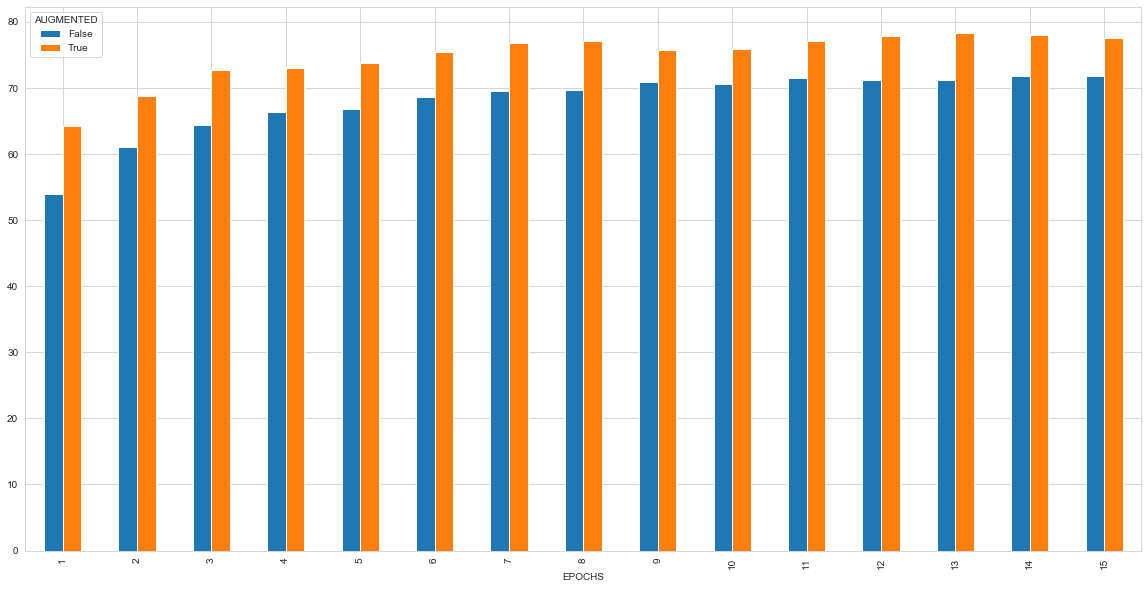

In [85]:
sns.set_style("whitegrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(20,10))
improved.groupby(['EPOCHS','AUGMENTED',]).max()['ACC_TEST'].unstack().plot.bar(ax=ax)

Wniosek:
Tym razem powiększone zbiory przyniosły zadawalające efekty.

In [13]:
model_best=ConvolutionalModelImproved(pooling_type='max',kernel_size=(3,3),first_dense_size=1600,dropout=0,batch_norm=True,residual=True)
model_best.fit(x_train,y_train,x_test,y_test,verbose=True,epochs=13,optimizer = tfa.optimizers.AdamW(learning_rate=0.0009,weight_decay=1e-4),augmented=True)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1, Loss: 1

In [14]:
def visualize_learning(model):
    sns.set()
    fig, (error_subplot, accuracy_subplot) = plt.subplots(1, 2,figsize=(15,5))
    epochs=[i+1 for i in range(len(model.train_learning_accuracy))]
    
    train_errors,test_errors=model.train_learning_losses,model.test_learning_losses
    train_accuracy,test_accuracy=model.train_learning_accuracy,model.test_learning_accuracy

    accuracy_subplot.plot(epochs,train_accuracy,linestyle='--', marker='o', color='green', label='Traing set accuracy')
    accuracy_subplot.plot(epochs,test_accuracy,linestyle='--', marker='o', color='blue', label='Test set accuracy')
    accuracy_subplot.set_title("Model accuracy change per epoch")
    accuracy_subplot.set_xlabel('Epochs')
    accuracy_subplot.set_ylabel('Loss')
    accuracy_subplot.legend(loc="upper left")
    
    error_subplot.plot(epochs,train_errors,linestyle='--', marker='o', color='red',label='Traing set loss')
    error_subplot.plot(epochs,test_errors,linestyle='--', marker='o', color='orange',label='Test set loss')
    error_subplot.set_title("Model loss change per epoch")
    error_subplot.set_xlabel('Epochs')
    error_subplot.set_ylabel('Loss')
    error_subplot.legend(loc="upper right")

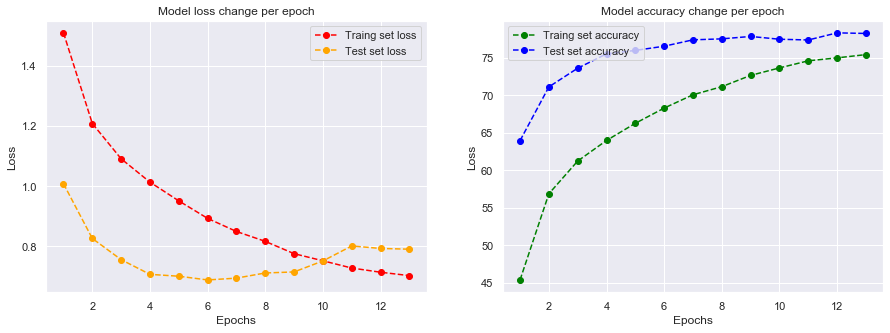

In [15]:
visualize_learning(model_best)

In [16]:
predicted_labels=model_best.predict(x_test)

[[782   8  59  14  19   8  14   6  62  28]
 [ 14 853   5   9   0   3  13   1  28  74]
 [ 28   5 689  54  64  42  81  15  14   8]
 [ 14   3  40 622  50 137  93  20  13   8]
 [ 10   2  58  55 740  25  56  44   9   1]
 [  7   3  29 158  36 682  44  24  11   6]
 [  3   1  19  28  21  12 907   2   6   1]
 [ 20   1  28  38  47  54  12 786   3  11]
 [ 31  11  16  10   5   6   9   1 897  14]
 [ 15  45   2  18   4   3  11   4  34 864]]


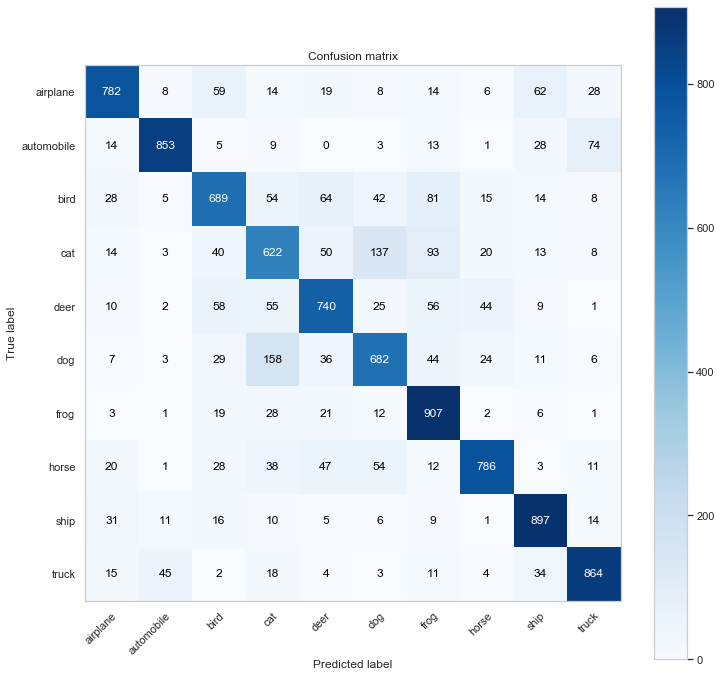

In [17]:
def visualize_confusion_matrix(y_true, y_pred, classes,
                          title=None):

    sns.set_style("whitegrid", {'axes.grid' : False})
    cm = confusion_matrix(y_true, y_pred)
    print(cm)

    fig, ax = plt.subplots(figsize=(12,12))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    
    #setting labels
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),

           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # label rotation
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # text annotations
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    #bug workarond
    ax.set_ylim(len(classes)-0.5, -0.5)
    return ax

visualize_confusion_matrix(y_test, predicted_labels, classes=ORDERED_CLASS_NAMES,
                      title='Confusion matrix')

In [18]:
def get_wrong_indices_list_per_class(class_id,labels,predicted):
    indexes=[]
    list_predicted=predicted.tolist()
    list_real=labels.transpose()[0].tolist()
    for i in range(len(list_real)):
        if list_real[i]!=list_predicted[i] and list_real[i]==class_id:
            indexes.append(i)
    return indexes

def get_class_indices(class_id,labels):
    result = np.where(labels == class_id)
    return result[0]

def visualize_n_images_horizontally(n, collection, indices_list, labels=None, predicted=None):
    sns.set_style("whitegrid", {'axes.grid' : False})
    fig, subplots = plt.subplots(1, n, figsize=(16,5))
    for subplot in subplots:
        number=random.choice(indices_list)
        ax=subplot.imshow(np.reshape(collection[number],(32, 32, 3)))
        title=str(number)
        if labels is not None:
            title+='-cl:'+ORDERED_CLASS_NAMES[labels[number][0]]
        if predicted is not None:
            title+='-p:'+ORDERED_CLASS_NAMES[predicted[number]]
        subplot.set_title(title)
    plt.show()

def visualize_n_represenative_class_examples(n,collection,labels):
    for i in range(len(ORDERED_CLASS_NAMES)):
        print(ORDERED_CLASS_NAMES[i])
        class_indices=get_class_indices(i,labels)
        visualize_n_images_horizontally(n,collection,class_indices,labels=labels)

def visualize_n_differing_for_each_class(n,collection,labels,predicted):
    for i in range(len(ORDERED_CLASS_NAMES)):
        print(ORDERED_CLASS_NAMES[i])
        mispredicted_indices=get_wrong_indices_list_per_class(i,labels,predicted)
        visualize_n_images_horizontally(n,collection,mispredicted_indices,predicted=predicted)
        

airplane


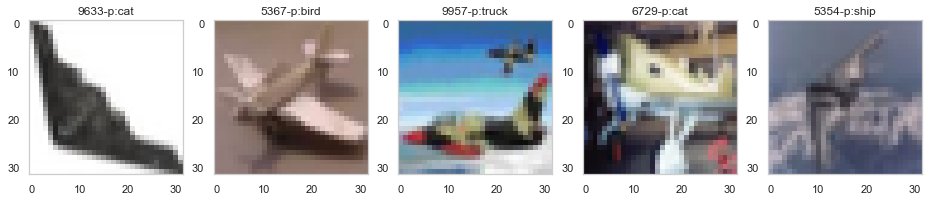

automobile


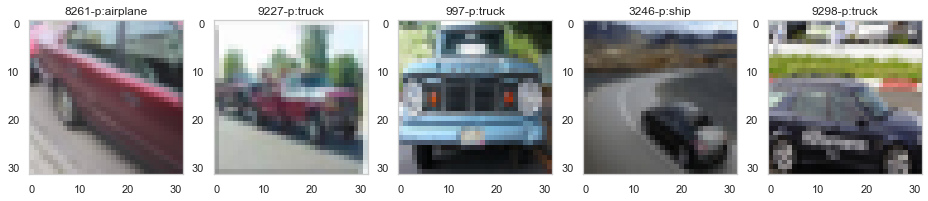

bird


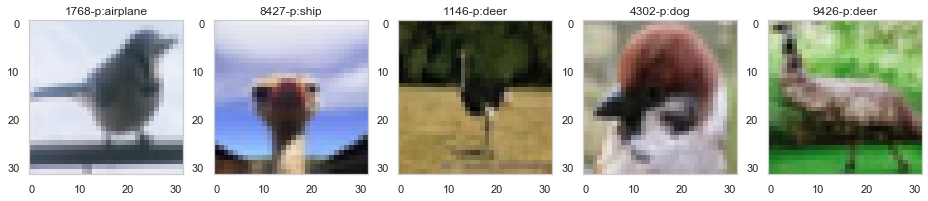

cat


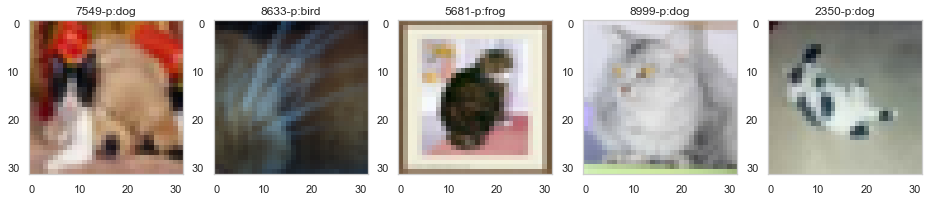

deer


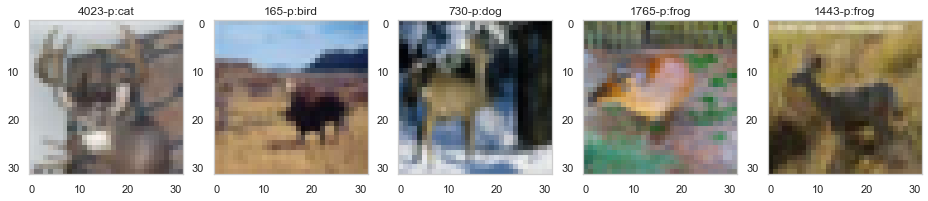

dog


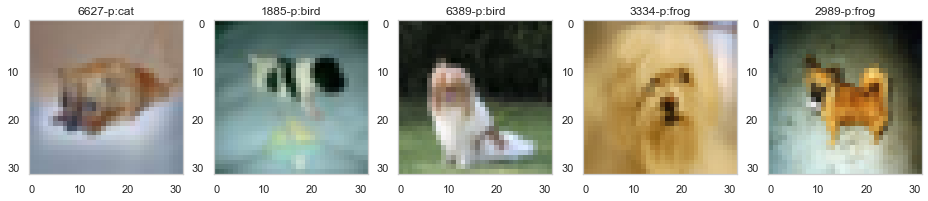

frog


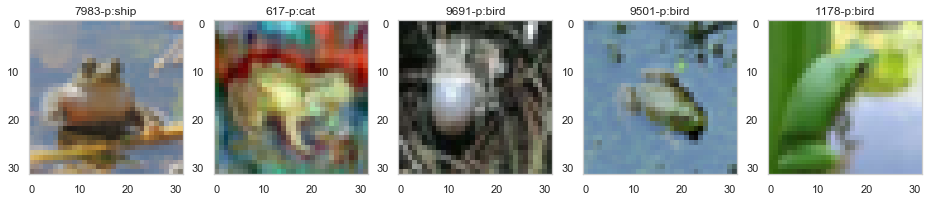

horse


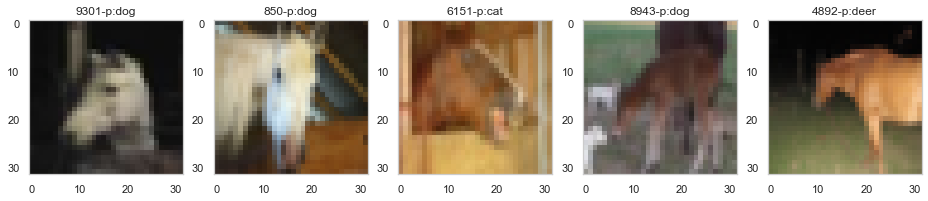

ship


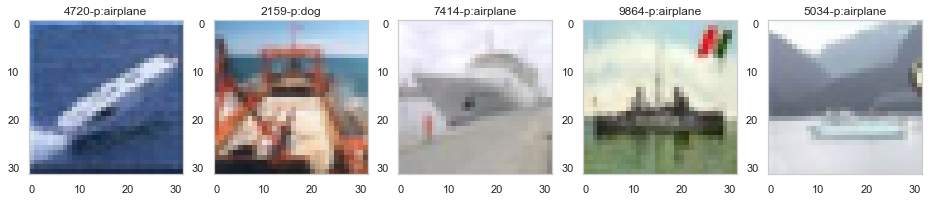

truck


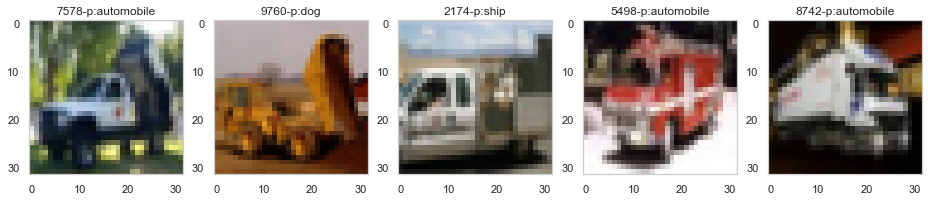

In [19]:
visualize_n_differing_for_each_class(5,x_test,y_test,predicted_labels)

In [20]:
from sklearn.metrics import classification_report

print(classification_report(y_test,predicted_labels, target_names=ORDERED_CLASS_NAMES))

              precision    recall  f1-score   support

    airplane       0.85      0.78      0.81      1000
  automobile       0.92      0.85      0.88      1000
        bird       0.73      0.69      0.71      1000
         cat       0.62      0.62      0.62      1000
        deer       0.75      0.74      0.75      1000
         dog       0.70      0.68      0.69      1000
        frog       0.73      0.91      0.81      1000
       horse       0.87      0.79      0.83      1000
        ship       0.83      0.90      0.86      1000
       truck       0.85      0.86      0.86      1000

    accuracy                           0.78     10000
   macro avg       0.78      0.78      0.78     10000
weighted avg       0.78      0.78      0.78     10000

